In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise import accuracy
from surprise.prediction_algorithms import SVD
pd.set_option('display.max_columns', None)

In [2]:
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

In [3]:
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [4]:
links.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [5]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [6]:
tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

In [7]:
movies.shape

(9742, 3)

In [8]:
movies[movies.duplicated(subset=['title'], keep = False)]

movieId                                   title  \
650       838                             Emma (1996)   
2141     2851                         Saturn 3 (1980)   
4169     6003  Confessions of a Dangerous Mind (2002)   
5601    26958                             Emma (1996)   
5854    32600                             Eros (2004)   
5931    34048                War of the Worlds (2005)   
6932    64997                War of the Worlds (2005)   
9106   144606  Confessions of a Dangerous Mind (2002)   
9135   147002                             Eros (2004)   
9468   168358                         Saturn 3 (1980)   

                                   genres  
650                  Comedy|Drama|Romance  
2141            Adventure|Sci-Fi|Thriller  
4169          Comedy|Crime|Drama|Thriller  
5601                              Romance  
5854                                Drama  
5931     Action|Adventure|Sci-Fi|Thriller  
6932                        Action|Sci-Fi  
9106  Comedy|Crime|Drama|Romance|Thriller  
9135                        Drama|Romance  
9468                      Sci-Fi|Thriller

In [9]:
movies = movies.drop_duplicates(subset = 'title', keep = 'first')

In [10]:
movies.shape

(9737, 3)

In [11]:
movie_data = pd.merge( ratings, movies, on = 'movieId')

In [12]:
movie_data.groupby('title')['rating'].mean().head()

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

In [13]:
df = pd.DataFrame(movie_data.groupby('title')['rating'].mean())

In [14]:
df.head()

rating
title                                          
'71 (2014)                                  4.0
'Hellboy': The Seeds of Creation (2004)     4.0
'Round Midnight (1986)                      3.5
'Salem's Lot (2004)                         5.0
'Til There Was You (1997)                   4.0

In [15]:
df.shape

(9719, 1)

In [16]:
df['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [17]:
df.head()

rating  rating_counts
title                                                         
'71 (2014)                                  4.0              1
'Hellboy': The Seeds of Creation (2004)     4.0              1
'Round Midnight (1986)                      3.5              2
'Salem's Lot (2004)                         5.0              1
'Til There Was You (1997)                   4.0              2

In [18]:
df.shape

(9719, 2)

<Figure size 576x432 with 0 Axes>

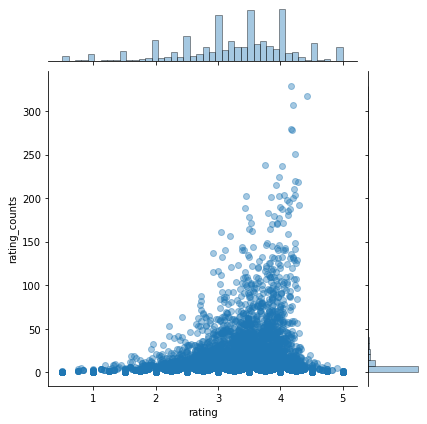

In [19]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=df, alpha=0.4)

#### The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

In [20]:
movie_data = movie_data.drop(columns='timestamp')
ratings = ratings.drop(columns='timestamp')

In [21]:
# making dummies of genres
movie_data = movie_data.join(movie_data.pop('genres').str.get_dummies('|'))

In [22]:
movie_data.head()

userId  movieId  rating             title  (no genres listed)  Action  \
0       1        1     4.0  Toy Story (1995)                   0       0   
1       5        1     4.0  Toy Story (1995)                   0       0   
2       7        1     4.5  Toy Story (1995)                   0       0   
3      15        1     2.5  Toy Story (1995)                   0       0   
4      17        1     4.5  Toy Story (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy  \
0          1          1         1       1      0            0      0        1   
1          1          1         1       1      0            0      0        1   
2          1          1         1       1      0            0      0        1   
3          1          1         1       1      0            0      0        1   
4          1          1         1       1      0            0      0        1   

   Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0          0       0     0        0        0        0       0         0    0   
1          0       0     0        0        0        0       0         0    0   
2          0       0     0        0        0        0       0         0    0   
3          0       0     0        0        0        0       0         0    0   
4          0       0     0        0        0        0       0         0    0   

   Western  
0        0  
1        0  
2        0  
3        0  
4        0

In [23]:
# Getting year from title
movie_data['year'] = movie_data['title'].str.extract(r"\(([0-9]+)\)", expand=False)


In [24]:
movie_data.head()

userId  movieId  rating             title  (no genres listed)  Action  \
0       1        1     4.0  Toy Story (1995)                   0       0   
1       5        1     4.0  Toy Story (1995)                   0       0   
2       7        1     4.5  Toy Story (1995)                   0       0   
3      15        1     2.5  Toy Story (1995)                   0       0   
4      17        1     4.5  Toy Story (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy  \
0          1          1         1       1      0            0      0        1   
1          1          1         1       1      0            0      0        1   
2          1          1         1       1      0            0      0        1   
3          1          1         1       1      0            0      0        1   
4          1          1         1       1      0            0      0        1   

   Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0          0       0     0        0        0        0       0         0    0   
1          0       0     0        0        0        0       0         0    0   
2          0       0     0        0        0        0       0         0    0   
3          0       0     0        0        0        0       0         0    0   
4          0       0     0        0        0        0       0         0    0   

   Western  year  
0        0  1995  
1        0  1995  
2        0  1995  
3        0  1995  
4        0  1995

<AxesSubplot:xlabel='year'>

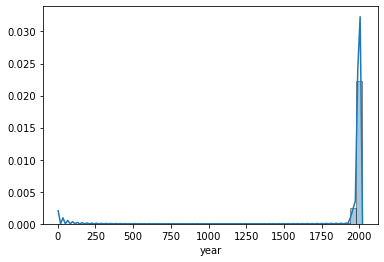

In [25]:
sns.distplot(movie_data['year'])

## Creating a matrix

In [26]:
matrix = movie_data.pivot_table(index='userId', columns='title', values='rating')

In [27]:
matrix.head()

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   
5                             NaN                              NaN   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      NaN                   NaN                          NaN   
2                      NaN                   NaN                          NaN   
3                      NaN                   NaN                          NaN   
4                      NaN                   NaN                          NaN   
5                      NaN                   NaN                          NaN   

title   *batteries not included (1987)  ...All the Marbles (1981)  \
userId                                                              
1                                  NaN                        NaN   
2                                  NaN                        NaN   
3                                  NaN                        NaN   
4                                  NaN                        NaN   
5                                  NaN                        NaN   

title   ...And Justice for All (1979)  \
userId                                  
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   
5                                 NaN   

title   00 Schneider - Jagd auf Nihil Baxter (1994)  1-900 (06) (1994)  \
userId                                                                   
1                                               NaN                NaN   
2                                               NaN                NaN   
3                                               NaN                NaN   
4                                               NaN                NaN   
5                                               NaN                NaN   

title   10 (1979)  10 Cent Pistol (2015)  10 Cloverfield Lane (2016)  \
userId                                                                 
1             NaN                    NaN                         NaN   
2             NaN                    NaN                         NaN   
3             NaN                    NaN                         NaN   
4             NaN                    NaN                         NaN   
5             NaN                    NaN                         NaN   

title   10 Items or Less (2006)  10 Things I Hate About You (1999)  \
userId                                                               
1                           NaN                                NaN   
2                           NaN                                NaN   
3                           NaN      

## Creating a simple correlation recommendation system

In [28]:
def corr_recommend(movie_name):
    movies_like = matrix.corrwith(matrix[movie_name])
    data = pd.DataFrame(movies_like, columns=['Correlation'])
    data.dropna(inplace=True)
    return data.sort_values('Correlation', ascending = False).head()
    

In [29]:
corr_recommend('Batman v Superman: Dawn of Justice (2016)')

C:\Users\Singh\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Singh\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Correlation
title                                               
Man on the Moon (1999)                           1.0
Down to Earth (2001)                             1.0
Shaolin Soccer (Siu lam juk kau) (2001)          1.0
Matilda (1996)                                   1.0
Babe: Pig in the City (1998)                     1.0

# Using Surprise

In [30]:
ratings.head()

userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

In [31]:
reader = Reader()
dfs = Dataset.load_from_df(ratings, reader)

In [32]:
# train test split
train, test = train_test_split(dfs, test_size = 0.2)

## KNN Basic

In [33]:
knn = knns.KNNBasic()
knn.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [34]:
#make predictions with knns
preds = knn.test(test)
print(accuracy.rmse(preds))
print(accuracy.mae(preds))

RMSE: 0.9591
0.9590696408846154
MAE:  0.7331
0.7331204398370423


## Similarity with KNN|

In [35]:
sim_cos = {'name':'cosine', 'user_based':True}

In [36]:
cos = knns.KNNBasic(sim_options=sim_cos)
cos.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [37]:
preds = cos.test(test)
print(accuracy.rmse(preds))
print(accuracy.mae(preds))

RMSE: 0.9847
0.9847399479886146
MAE:  0.7570
0.7570031014287144


### Pearson coefficient

In [38]:
pearson = {'name':'pearson', 'user_based':True}

In [39]:
pearson_knn = knns.KNNBasic(sim_options = pearson)
pearson_knn.fit(train)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [40]:
preds = pearson_knn.test(test)
print(accuracy.rmse(preds))
print(accuracy.mae(preds))

RMSE: 0.9847
0.9846899112729232
MAE:  0.7583
0.7583203375387422


In [44]:
pearson_knn.predict(1,1)

Prediction(uid=1, iid=1, r_ui=None, est=3.844482739338362, details={'actual_k': 40, 'was_impossible': False})

### SVD

In [49]:
svd = SVD(n_factors = 50, n_epochs = 5)

In [50]:
svd.fit(train)

In [51]:
preds = svd.test(test)
print(accuracy.rmse(preds))
print(accuracy.mae(preds))

RMSE: 0.8924
0.89236366348322
MAE:  0.6893
0.6892878158542962
